# VGG16 모델 활용 이미지 식별 모델
- data : cifar10

In [206]:
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.utils import set_random_seed, plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPool2D, Input
from keras.applications.vgg16 import preprocess_input, decode_predictions, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [207]:
(x_train, y_train), (x_test, y_test)=load_data()

In [208]:
x_train, x_val, y_train, y_val=train_test_split(
x_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

In [209]:
# 스케일링
x_train=x_train/255.0
x_test=x_test/255.0
x_val=x_val/255.0

## 모델

In [210]:
x_train.shape, x_test.shape

((40000, 32, 32, 3), (10000, 32, 32, 3))

In [211]:
input_tensor=Input(shape=(32, 32, 3))

In [212]:
model=VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

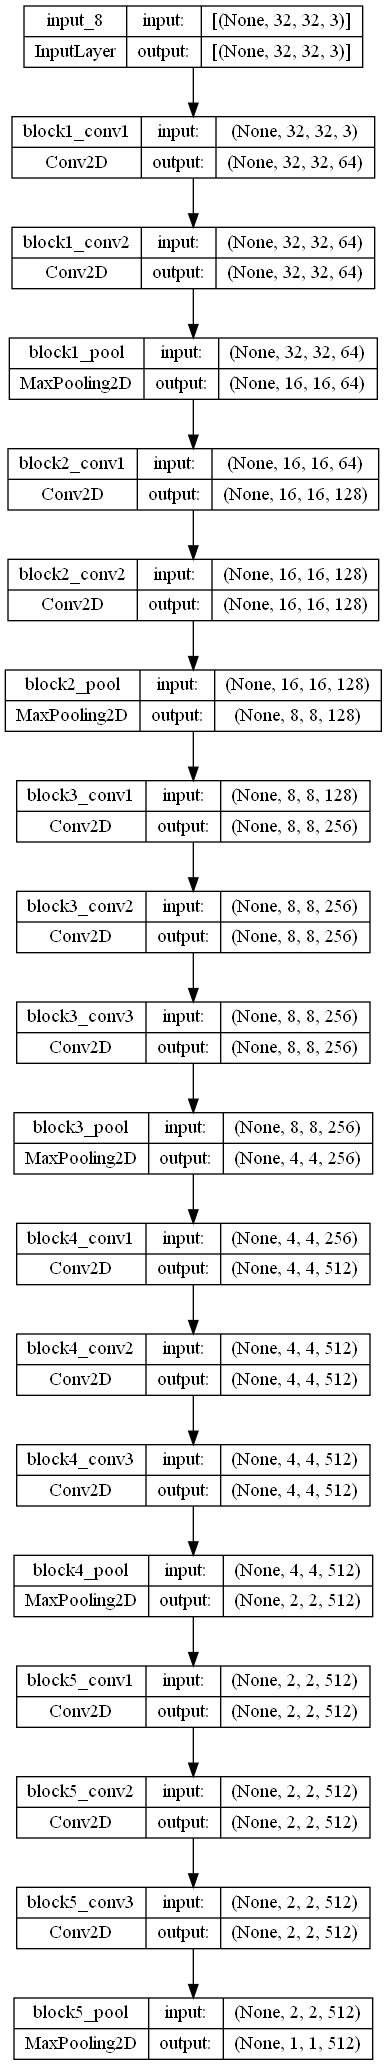

In [213]:
plot_model(model, show_shapes=True)

In [214]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [215]:
layer_dict

{'input_8': <keras.engine.input_layer.InputLayer at 0x1c3d63d7df0>,
 'block1_conv1': <keras.layers.convolutional.conv2d.Conv2D at 0x1c3d4e339a0>,
 'block1_conv2': <keras.layers.convolutional.conv2d.Conv2D at 0x1c3d4e33a60>,
 'block1_pool': <keras.layers.pooling.max_pooling2d.MaxPooling2D at 0x1c3d49ec910>,
 'block2_conv1': <keras.layers.convolutional.conv2d.Conv2D at 0x1c3d49c7520>,
 'block2_conv2': <keras.layers.convolutional.conv2d.Conv2D at 0x1c3d49d65e0>,
 'block2_pool': <keras.layers.pooling.max_pooling2d.MaxPooling2D at 0x1c3d4ac9220>,
 'block3_conv1': <keras.layers.convolutional.conv2d.Conv2D at 0x1c3d4ac9730>,
 'block3_conv2': <keras.layers.convolutional.conv2d.Conv2D at 0x1c3d63a9670>,
 'block3_conv3': <keras.layers.convolutional.conv2d.Conv2D at 0x1c3d63b54f0>,
 'block3_pool': <keras.layers.pooling.max_pooling2d.MaxPooling2D at 0x1c3d63b9340>,
 'block4_conv1': <keras.layers.convolutional.conv2d.Conv2D at 0x1c3ce21aac0>,
 'block4_conv2': <keras.layers.convolutional.conv2d.Conv

In [216]:
x=layer_dict['block5_pool'].output

In [217]:
x=Flatten()(x)

In [218]:
x=Dense(2048, activation='relu')(x)

In [219]:
x=Dropout(0.5)(x)

In [220]:
x=Dense(1024, activation='relu')(x)

In [221]:
x=Dropout(0.5)(x)

In [222]:
x=Dense(10, activation='softmax')(x)

In [223]:
new_model=Model(inputs=model.input, outputs=x)

In [224]:
new_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [225]:
new_model.layers

In [226]:
for layer in new_model.layers[:19]:
    layer.trainable=False

In [227]:
new_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [228]:
new_model.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

In [229]:
stopCB=EarlyStopping(monitor='val_accuracy', patience=3)

MODEL_PATH='model.{epoch:02d}-{val_loss:.2f}.h5'
modelCB=ModelCheckpoint(filepath=MODEL_PATH,
                       save_best_only=True)

In [230]:
history=new_model.fit(x_train, y_train, epochs=100,
                     validation_data=(x_val, y_val),
                     callbacks=[stopCB, modelCB])

Epoch 1/100
1250/1250 [==============================] - 401s 319ms/step - loss: 1.5045 - accuracy: 0.4719 - val_loss: 1.2627 - val_accuracy: 0.5609
Epoch 2/100
1250/1250 [==============================] - 417s 334ms/step - loss: 1.3411 - accuracy: 0.5314 - val_loss: 1.2286 - val_accuracy: 0.5702
Epoch 3/100
1250/1250 [==============================] - 417s 333ms/step - loss: 1.2911 - accuracy: 0.5489 - val_loss: 1.2015 - val_accuracy: 0.5811
Epoch 4/100
1250/1250 [==============================] - 397s 318ms/step - loss: 1.2553 - accuracy: 0.5635 - val_loss: 1.1804 - val_accuracy: 0.5920
Epoch 5/100
1250/1250 [==============================] - 401s 321ms/step - loss: 1.2320 - accuracy: 0.5691 - val_loss: 1.1741 - val_accuracy: 0.6002
Epoch 6/100
1250/1250 [==============================] - 400s 320ms/step - loss: 1.2044 - accuracy: 0.5769 - val_loss: 1.1923 - val_accuracy: 0.5958
Epoch 7/100
1250/1250 [==============================] - 403s 322ms/step - loss: 1.1824 - accuracy: 0.5881

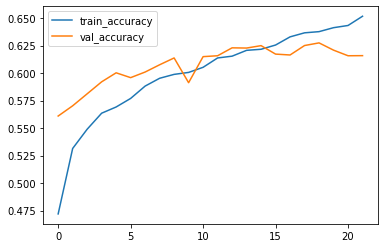

In [231]:
plt.plot(history.epoch, history.history['accuracy'], label='train_accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [237]:
new_model.evaluate(x_test, y_test)

313/313 [==============================] - 35s 113ms/step - loss: 1.1538 - accuracy: 0.6055


[1.153793454170227, 0.6054999828338623]

In [245]:
for i in range(3):
    print(np.round(new_model.predict(x_test[[i]])))

1/1 [==============================] - 0s 25ms/step
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
1/1 [==============================] - 0s 26ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
1/1 [==============================] - 0s 34ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [240]:
for i in range(3):
    print(y_test[i])

[3]
[8]
[8]
